## Описание проекта

Служба такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо построить модель прогнозирующую количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*'.

### План по выполнению проекта:  
1. Загрузим данные и выполним их ресемплирование по одному часу.  
2. Проанализируем данные.  
3. Разделим выборку на обучающую и тестовую (90:10).

4. Обучим 3 модели. Расчитаем значение метрики RMSE для каждой.

5. Проверим данные на тестовой выборке.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import statsmodels.tsa.api as smt
import statsmodels.api as sm
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error 

import warnings # отключение предупреждений
warnings.filterwarnings('ignore')

# 1. Подготовка


Загрузим файл и одновременно преобразуем столбец с датой и временем в индекс `datetime`. 

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'], dayfirst=True)
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


# 2. Анализ

Проверим, что наш временной ряд непрерывен. Количество строк должно соответствовать общему времени наблюдений делёное на 10 минут (600 сек). 

In [4]:
print("Количество строк: ", data.shape)
dt = (data.index[-1] - data.index[0])
print("Количество наблюдений исходя из общего времени : ", dt.total_seconds()/ 600+1)

Количество строк:  (26496, 1)
Количество наблюдений исходя из общего времени :  26496.0


Равенство говорит о том, что временной ряд не прерывается, в нем нет пропусков.


Визуализируем данные о количестве заказов.

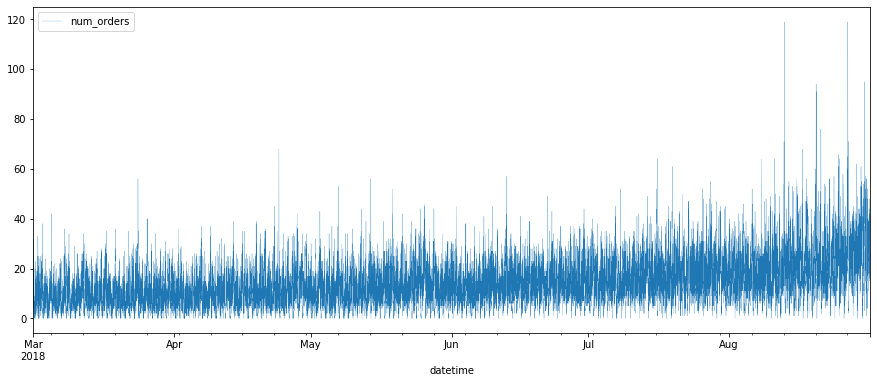

In [5]:
data.plot(figsize=(15,6), linewidth=0.2)

Из графика видно, что наш ряд имеет выбросы, которые влияют на разброс. Ресемплируем наблюдения, перейдя к часовому интервалу и среднему значению заказов за 1 час.


Для наглядности, напишем функцию изображающую тренд числа заказов и, чтобы лучше была видна динамика, сгладим наблюдения по дням. Дополнительно изобразим верхний/нижний 5%-й квантиль нормального распределения (доверительный интервал).

In [6]:
data_h = data.resample('H', how='mean')

In [7]:
import matplotlib.pyplot as plt

def plotMovingAverage(series, n): # series - наблюдения, n - размер окна

    rolling_mean = series.rolling(window=n).mean()

    rolling_std =  series.rolling(window=n).std() #строим доверительные интервалы для сглаженных значений
    upper_bond = rolling_mean+1.96*rolling_std # верхняя граница
    lower_bond = rolling_mean-1.96*rolling_std # ниженяя граница

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")

    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    plt.plot(series[n:], label="Actual values", linewidth=0.15)
    plt.legend(loc="upper left")
    plt.grid(True)


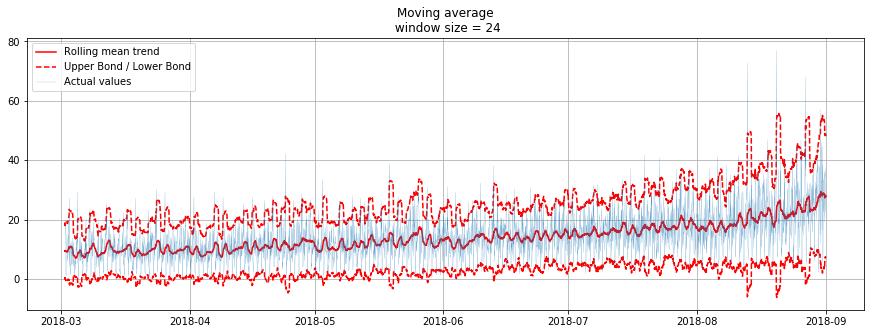

In [8]:
plotMovingAverage(data_h, 24)

В новом графике стало меньше ярких выбросов и заметен восходящий тренд. Можно сделать вывод о том, что ряд не является стационарным.


Для проверки стационарности проведем тест Дикки-Фуллера на наличие единичных корней.

Нулевая гипотеза теста состоит в том, что временной ряд может быть представлен единичным корнем, который не является стационарным, а альтернативная в том, что временной ряд стационарен. Таким образом, если p-value больше критического значения, отвергаем нулевую гипотезу.

Напишем функцию для проверки на стационарность ряда.

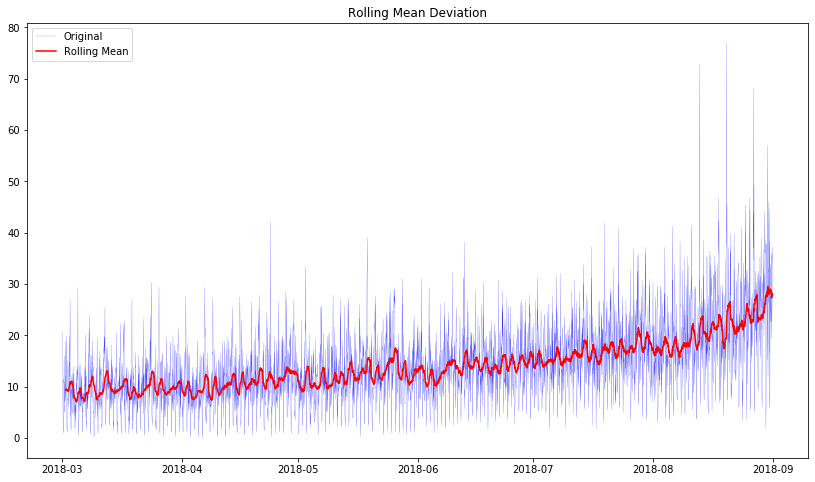

Результаты теста Дики—Фуллера

Test Statistics                  -3.068924
p-value                           0.028940
No. of lags used                 30.000000
Number of observations used    4385.000000
critical value (1%)              -3.431842
critical value (5%)              -2.862199
critical value (10%)             -2.567121
dtype: float64 

Есть единичные корни, ряд не стационарен.


In [9]:
import matplotlib

matplotlib.rc('figure', figsize=(14, 8))

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(24).mean() # cкользящее среднее

    plt.plot(timeseries, color='blue',label='Original', linewidth=0.15)
    plt.plot(rolmean, color='red', label='Rolling Mean')

    plt.legend(loc='best')
    plt.title('Rolling Mean Deviation')
    plt.show()
    
    print("Результаты теста Дики—Фуллера\n")
    df_test = adfuller(timeseries['num_orders'],autolag='AIC')
    output = pd.Series(df_test[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in df_test[4].items():
        output['critical value (%s)'%key] =  values
    print(output, '\n')
    
    if df_test[0] > df_test[4]['1%']: 
        print('Есть единичные корни, ряд не стационарен.')
    else:
        print('Единичных корней нет, ряд стационарен.')

    
test_stationarity(data_h)

Как и следовало ожидать, исходный ряд стационарным не является, критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня.  


Для представления зависимости по разнесённым по времени наблюдениям рассмотрим график автокорреляционной и частной автокорреляционной функции.

In [10]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series): # сработает, если (вдруг) наши данные не в структуре Series (после преобразований)
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax, linewidth=0.3)
        ts_ax.set_title('Анализ временного ряда')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.028940


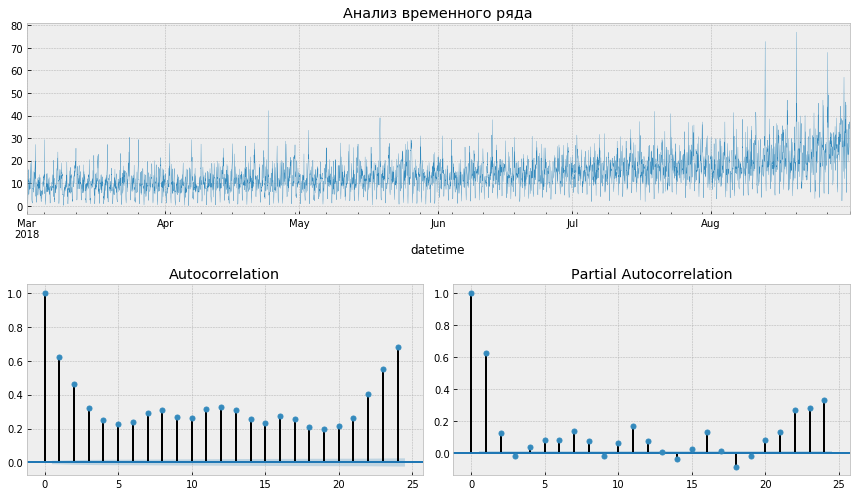

In [11]:
tsplot(data_h.num_orders, lags=24)

График автокорреляции показывает наличие тренда.

Так как на графике частной автокорреляционной функции значим лишь один лаг, чтобы привести ряд к стационарному виду, возьмем первые разности.

Критерий Дики-Фуллера: p=0.000000


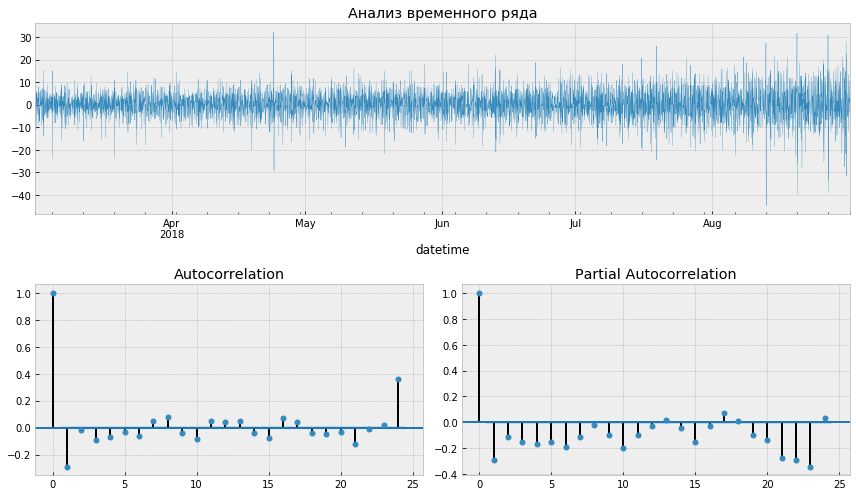

In [12]:
data_diff = (data_h.num_orders - data_h.num_orders.shift(1)).dropna()

tsplot(data_diff[1:], lags=24)

Критерий Дики-Фуллера теперь отвергает нулевую гипотезу о нестационарности, автокорреляционная функция выглядит лучше, показывая небольшое число значимых лагов и тренд отсутствует. Таким образом наш интегрированный ряд первого порядка теперь является стационарным.

Проверим, есть ли сезонность (повторяющийся паттерн) в нашем временном ряду. Определить наличие сезонности можно при помощи функции `seasonal_decompose` из пакета `statsmodels`, которая разложит временной ряд на три компонента — трендовый, сезонный и остаток. Затем построим коррелограмму и посмотрим на периоды, когда кореляция выше. Возьмем 1 день, укрупним данные. 

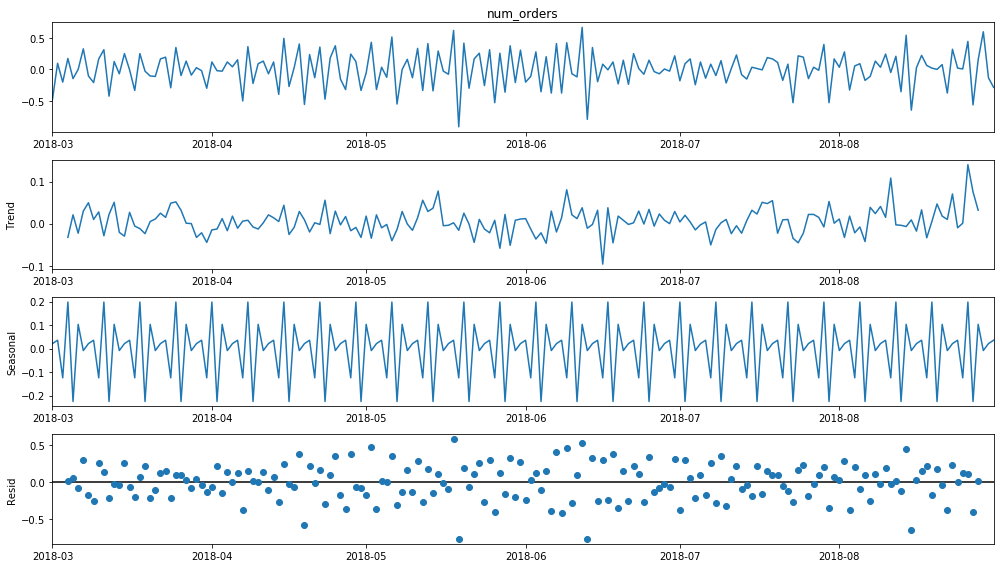

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

data_d = data_diff.resample("D").mean()

result = seasonal_decompose(data_d, model='additive')
result.plot();

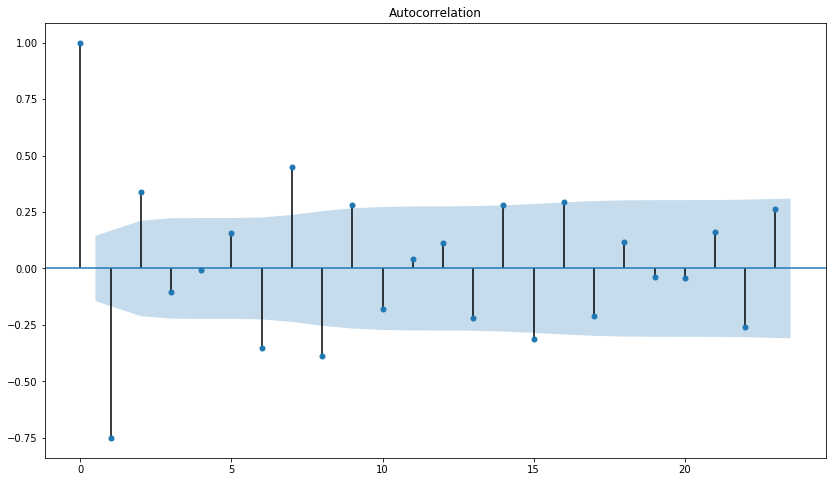

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data_d.diff().dropna());

Определённо сезонность присутвует — наблюдаем корреляцию с лагом каждые 7 шагов/дней. Устраним сезонность, продифференцировав временной ряд.

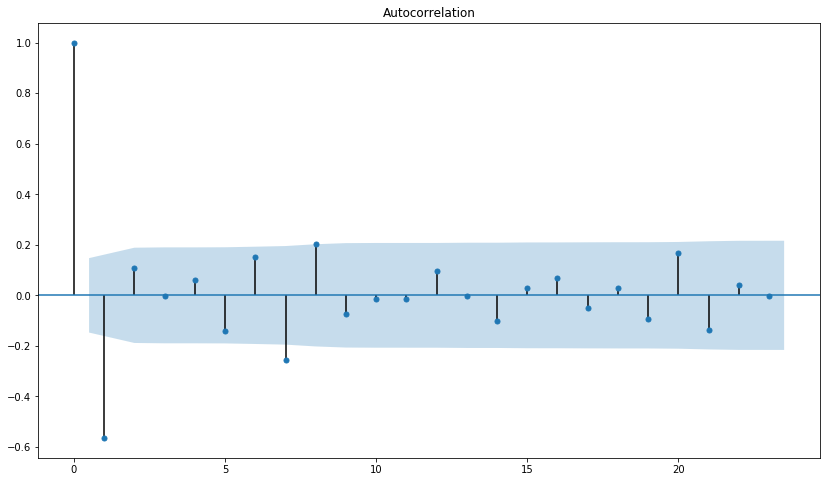

In [15]:
data_dd = data_d.diff(7).dropna()
plot_acf(data_dd);

Мы избавились от сезонности, продифференцировав дневной ряд, соответственно, необходимо то же самое с часовым временным рядом.

In [16]:
data_diff = data_diff.diff(7*24).dropna() # периодически повторяющиеся явления каждые 7 дней * 24 часа

# 3. Обучение

Для анализа качества предсказаний выберем 3 модели - LinearRegression, XGBoost и метод для прогнозирования временных рядов ARIMA.  


Напишем функцию для разделения нашей выборки на обучающую и тестовую +  
#### Создадим дополнительные признаки.  
Извлечём из календарных данных (дата и время) следующие признаки: час, день недели и выходной день. Добавим их в качестве категориальных переменных в наш датасет. Кроме этого, добавим "отстающие значения" (lag features - предыдущие значения временного ряда) и скользящий средний признак (rolling feature), которые подскажут модели, будет ли функция x(t) расти/уменьшаться и общий тренд.

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    if not isinstance(data, pd.DataFrame): # сработает, если (вдруг) наши данные не в структуре DataFrame (после преобразований)
        data = pd.DataFrame(data)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() # скользящий средний
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag) # отстающие значения
            
        #Комментарий наставника: строку выше можно вынести из цикла
        
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()

    X_train = train.drop(['num_orders'], axis=1)
    y_train = train['num_orders']
    X_test = test.drop(['num_orders'], axis=1)
    y_test = test['num_orders']
    return X_train, y_train, X_test, y_test  

In [18]:
X_train, y_train, X_test, y_test = make_features(data_diff, 2, 3)

print('Обучающая выборка:', X_train.shape)
print('Целевой признак обучающей выборки:', y_train.shape, '\n')

print('Тестовая выборка:',X_test.shape)
print('Целевой признак тестовой выборки:', y_test.shape, '\n')

X_train.head()

Обучающая выборка: (3819, 6)
Целевой признак обучающей выборки: (3819,) 

Тестовая выборка: (425, 6)
Целевой признак тестовой выборки: (425,) 



,hour,weekday,is_weekend,rolling_mean,lag_1,lag_2
datetime,,,,,,
2018-03-08 04:00:00,4,3,0,-0.944444,1.333333,0.166667
2018-03-08 05:00:00,5,3,0,1.333333,2.500000,1.333333
2018-03-08 06:00:00,6,3,0,0.333333,-2.833333,2.500000
2018-03-08 07:00:00,7,3,0,-0.444444,-1.000000,-2.833333
2018-03-08 08:00:00,8,3,0,-0.722222,1.666667,-1.000000


### LinearRegression


Обучим модель, расчитаем целевую метрику RMSE и визуализируем предсказания.

In [19]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

predicted_train_lr = model_lr.predict(X_train)
rmse_train_lr = rmse(y_train, predicted_train_lr)

print("LinearRegression - RMSE на обучающей выборке:", rmse_train_lr)

LinearRegression - RMSE на обучающей выборке: 4.596034139008631


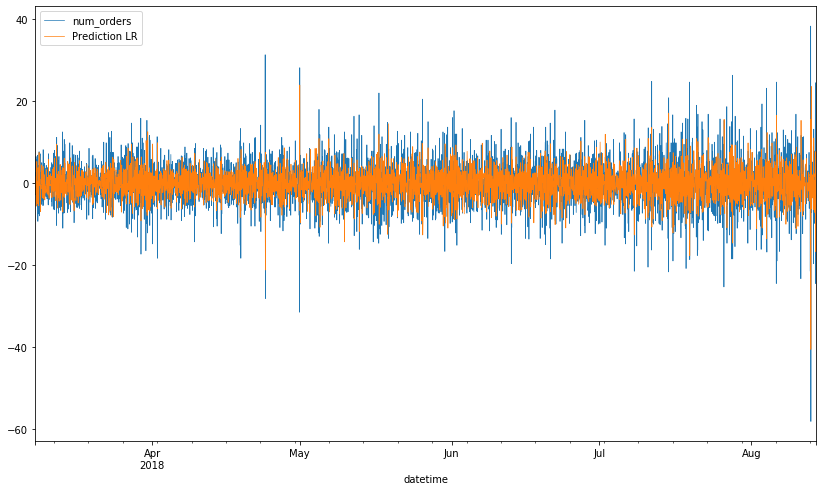

In [20]:
train_forecast_lr = pd.DataFrame(predicted_train_lr,index = y_train.index,columns=['Prediction LR'])
pd.concat([y_train, train_forecast_lr],axis=1).plot(linewidth=0.7)

Модель показала неплохой результат. График предсказаний повторяет обучающие данные.


---


### XGBoost   

Обучим модель и подберём гиперпараметры на кросс-валидации. Расчитаем целевую метрику RMSE и визуализируем предсказания.

In [21]:
my_scorer = make_scorer(rmse, greater_is_better=False) # зададим параметр целевой метрики качества (чем меньше, тем лучше)
cv = KFold(n_splits=5,random_state=42, shuffle=False)

xgbr = xgb.XGBRegressor(num_boost_round=999, early_stopping_rounds=10, silent=True)
param_xgb = {'max_depth': sp_randint(10,20),
                 'min_child_weight': sp_randint(1,5),
                 'subsample': [.9, 1.0]}
        
random_search_xgb = RandomizedSearchCV(xgbr, param_distributions=param_xgb,
                                   n_iter=10, cv=cv, scoring=my_scorer, random_state=42)

random_search_xgb.fit(X_train, y_train)

print(random_search_xgb.best_params_)
    
pred_train_xgb = random_search_xgb.predict(X_train)
rmse_train_xgb = rmse(y_train, pred_train_xgb)

print('\nXGBoost - RMSE на обучающей выборке:', rmse_train_xgb)

{'max_depth': 16, 'min_child_weight': 4, 'subsample': 0.9}

XGBoost - RMSE на обучающей выборке: 0.9741325266604832


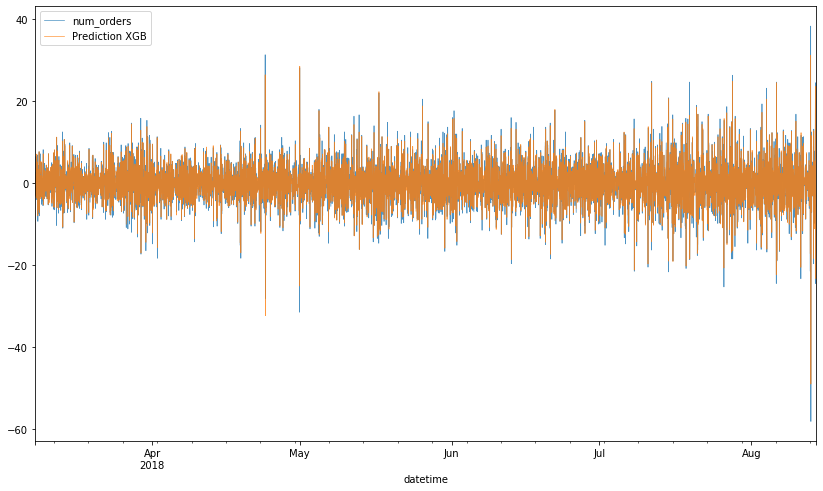

In [22]:
train_forecast_xgb = pd.DataFrame(pred_train_xgb,index = y_train.index,columns=['Prediction XGB'])
pd.concat([y_train,train_forecast_xgb],axis=1).plot(linewidth=0.7, alpha=0.8)

Как видим, среднеквадратическая ошибка на обучающей выборке меньше единицы, что подтверждается практически перекрывающимися графиками. XGBoost отлично справляется с предсказанием!  


Проанализируем, какой параметр из созданных является наиболее важным для модели. 

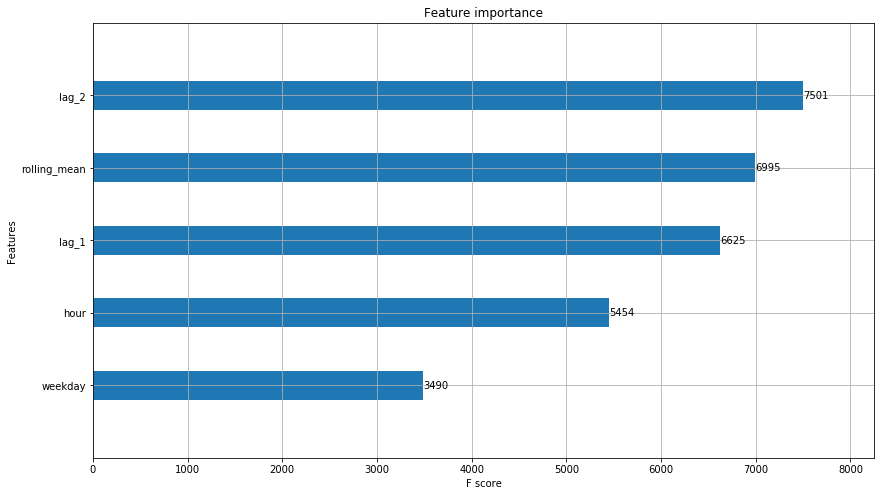

In [23]:
model_xgbr = xgb.XGBRegressor(max_depth=16, min_child_weight=4, subsample=0.9, num_boost_round=999, 
                              early_stopping_rounds=10, silent=True)
xgbr_t = model_xgbr.fit(X_train, y_train)
plot_importance(xgbr_t, height=0.4)

Наиболее критичными/важными признаками для предсказаний модели XGBoost стали отстающие значения (2 предыдущих значения) и скользящий средний признак. Календарные признаки оказанились менее важными.

### ARIMA


ARIMA описывает корреляцию между точками данных и учитывает разницу значений. Однако, процессы подготовки и настройки параметров в конечном итоге занимают много времени - перед реализацией ARIMA необходимо сделать ряд стационарным и определить значения d, p и q. Чтобы упростить себе задачу, воспользуемся чудо-функцией `auto_arima`, которая упрощает процесс, поскольку она устраняет необходимость в вышеперечисленных шагах и автоматизирует подбора параметров.


Перед обучением, разделим (неинтегрированный) датасет на обучающую/тестовую выборки и визуализируем их на графике.

Установим библиотеку Pmdarima.

In [24]:
train, test = train_test_split(data_h, shuffle=False, test_size=0.1)

In [25]:
#pip install --user pmdarima

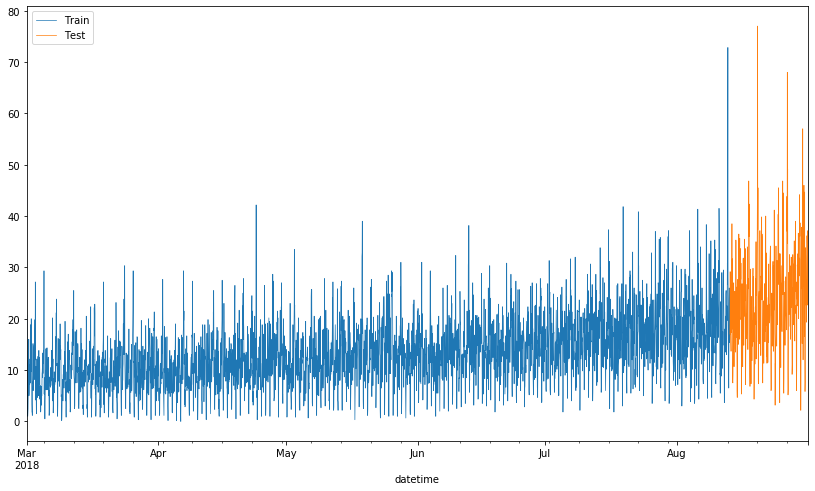

In [26]:
train['num_orders'].plot(linewidth=0.7, label='Train')
test['num_orders'].plot(linewidth=0.7, label='Test')
plt.legend(loc="upper left")

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(1,1,1,2) [intercept=True]; AIC=24216.524, BIC=24254.246, Time=27.756 seconds
Fit ARIMA(0,0,0)x(0,1,0,2) [intercept=True]; AIC=26867.584, BIC=26880.158, Time=0.256 seconds
Fit ARIMA(1,0,0)x(1,1,0,2) [intercept=True]; AIC=25904.911, BIC=25930.059, Time=2.231 seconds
Fit ARIMA(0,0,1)x(0,1,1,2) [intercept=True]; AIC=24420.417, BIC=24445.565, Time=8.711 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 2); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA(0,0,0)x(0,1,0,2) [intercept=False]; AIC=26865.584, BIC=26871.871, Time=0.224 seconds
Fit ARIMA(1,0,1)x(0,1,1,2) [intercept=True]; AIC=24230.240, BIC=24261.676, Time=12.971 seconds
Near non-invertible roots for order (1, 0, 1)(0, 1, 1, 2); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(1,0,1)x(1,1,0,2) [intercept=True]; AIC=25008.291, BIC=25039.726,

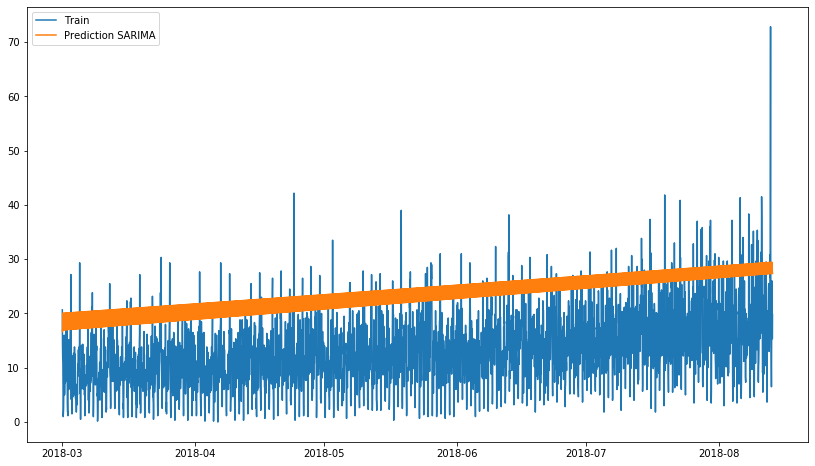

In [27]:
from pmdarima import auto_arima

model_arima = auto_arima(train, trace=True,start_p=1, start_q=1, start_P=1, start_Q=1,
                  max_p=3, max_q=3, max_P=3, max_Q=3, m=2, seasonal=True,
                  stepwise=True, suppress_warnings=True, D=1, max_D=3,
                  error_action='ignore',approximation = False, n_jobs=-1)
                         
print(f'best_aic: {model_arima.aic()}')
                         
model_arima.fit(train)

train_forecast_arima = model_arima.predict(n_periods=len(train)) # предсказания временного интервала обучающей выборки
train_forecast_arima = pd.DataFrame(train_forecast_arima,index = train.index,columns=['Prediction ARIMA'])

plt.plot(train, label='Train') #строим прогноз для обучающей выборки
plt.plot(train_forecast_arima, label='Prediction SARIMA')
plt.legend(loc="upper left")
plt.show()

In [28]:
print('SARIMA - RMSE на обучающей выборке:', mean_squared_error(train, train_forecast_arima, squared=False))

SARIMA - RMSE на обучающей выборке: 11.706951166609239


In [35]:
print(model_arima.predict(n_periods=len(train))[:10])
print(model_arima.predict(n_periods=len(test))[:10])

[16.63149471 17.25413734 20.05154032 18.52328327 16.98096269 16.97499997
 20.05477081 18.4738192  16.98211452 16.97399123]
[16.63149471 17.25413734 20.05154032 18.52328327 16.98096269 16.97499997
 20.05477081 18.4738192  16.98211452 16.97399123]


In [29]:
print(train_forecast_arima)

                     Prediction ARIMA
datetime                             
2018-03-01 00:00:00         16.631495
2018-03-01 01:00:00         17.254137
2018-03-01 02:00:00         20.051540
2018-03-01 03:00:00         18.523283
2018-03-01 04:00:00         16.980963
...                               ...
2018-08-13 09:00:00         27.364593
2018-08-13 10:00:00         29.443775
2018-08-13 11:00:00         28.210284
2018-08-13 12:00:00         27.729400
2018-08-13 13:00:00         27.375002

[3974 rows x 1 columns]


Это наихудший результат предсказаний. Предположим, что плохое качество модели связано с необходимостью более тонкой настройки параметров.


Проверим качество моделей на тестовой выборке.

# 4. Тестирование


Используем тестовую выборку на обученных моделях. Расчитаем среднеквадратичную ошибку и визуализируем предсказания моделей.

In [30]:
pred_test_lr = model_lr.predict(X_test)
rmse_test_lr = rmse(y_test, pred_test_lr)
print("LinearRegression - RMSE тестовой выборки: ", rmse_test_lr)

pred_test_xgb = random_search_xgb.predict(X_test)
xgb_rmse = rmse(y_test, pred_test_xgb)
print('\nXGBoost - RMSE на тестовой выборке:', xgb_rmse)

pred_test_arima = model_arima.predict(n_periods=len(test))
print('\nSARIMA - RMSE на тестовой выборке:', mean_squared_error(test, pred_test_arima, squared=False))

LinearRegression - RMSE тестовой выборки:  6.463942099571976

XGBoost - RMSE на тестовой выборке: 6.817271822482889

SARIMA - RMSE на тестовой выборке: 10.6344253656837


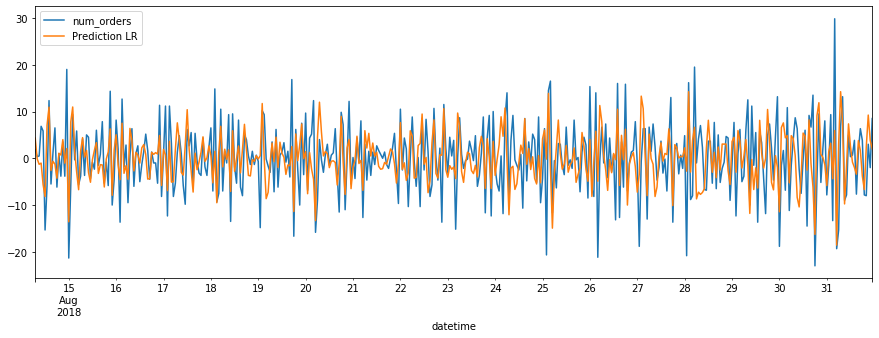

In [31]:
future_forecast_lr = pd.DataFrame(pred_test_lr,index = y_test.index,columns=['Prediction LR'])
pd.concat([y_test,future_forecast_lr],axis=1).plot(figsize=(15, 5))

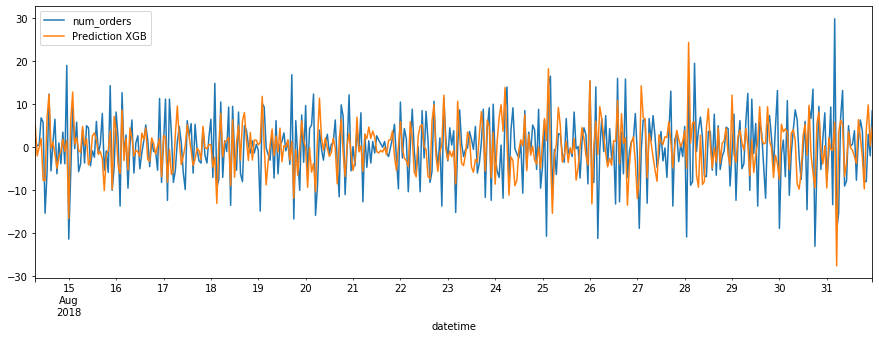

In [32]:
future_forecast_xgb = pd.DataFrame(pred_test_xgb,index = y_test.index,columns=['Prediction XGB'])
pd.concat([y_test,future_forecast_xgb],axis=1).plot(figsize=(15, 5))

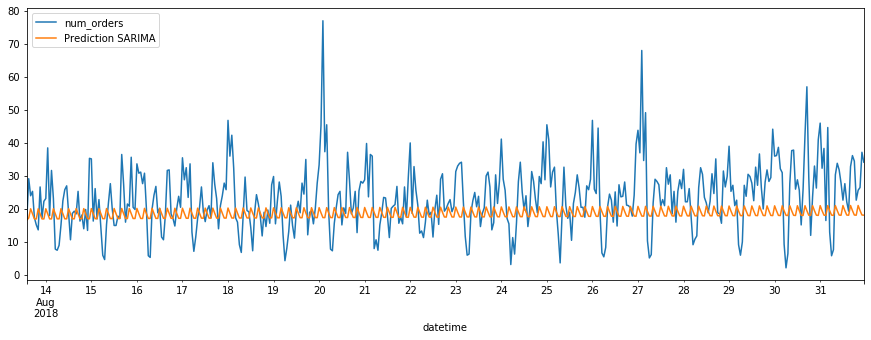

In [33]:
pred_test_arimadf = pd.DataFrame(pred_test_arima,index = test.index,columns=['Prediction SARIMA'])
pd.concat([test,pred_test_arimadf],axis=1).plot(figsize=(15, 5))

plt.legend(loc="upper left")

### Вывод  
Лучший результат показала модель LinearRegression (RMSE на тестовой выборке 6.46). Немного хуже показала результат XGBoost (RMSE на тестовой выборке 6.82). Графики спрогнозированных моделями значений наиболее точно повторяет исторические (исходные) данные о количестве заказов такси.  

Заметно хуже показала результат модель SARIMA (RMSE на тестовой выборке 10.63). Возможно, это произошло из-за того, что функция `auto_arima` не смогла подобрать необходимые параметры d, p и q. Вероятно, вручную можно подобрать лучшие параметры.